In [113]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import yaml

from model.model import get_model
from data_loader import TrainDataModule, get_all_test_dataloaders, get_normal_test_dataloader, get_train_dataloader
from ganomaly_eval import GanomalyEvaluator, EvalType
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
# autoreload imported modules
%load_ext autoreload
%autoreload 2
%matplotlib inline


# with open("./configs/ganomaly_config.yaml", "r") as f:
best = "/home/marcel/Projects/uni/mad_seminar/models/dulcet-music-21/ganomaly_config.yaml"
test = "./configs/ganomaly_config.yaml"
with open(best, "r") as f:
    config = yaml.safe_load(f)

# Reproducibility
pl.seed_everything(config["seed"])

test_dataloaders = get_all_test_dataloaders(config['split_dir'], config['target_size'], config['batch_size'])


Global seed set to 42


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
# load model from checkpit
# from model.ganomaly.lightning_model import Ganomaly


model = get_model(config)

# model = Ganomaly(
#     batch_size=256,
#     input_size=(64, 64),
#     latent_vec_size=256,  # 256,
#     wadv=1,
#     wcon=50,
#     wenc=1,
#     # lr=config["lr"],
#     beta1=0.5,
#     beta2=0.999,
# )
# custom_cp = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_1/checkpoints/epoch=149-step=300.ckpt"
# Initialize the model by loading from the checkpoint
best_cp = "models/dulcet-music-21/epoch=149-step=2400.ckpt"
cp = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_56/checkpoints/epoch=81-step=984.ckpt"
model.load_state_dict(torch.load(best_cp)["state_dict"])
# model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.eval()

Loading model ganomaly


In [115]:

normal_test_dataloader = get_normal_test_dataloader(
    config["split_dir"], config["target_size"], config["batch_size"]
)
# train_dataloader = get_train_dataloader(config['split_dir'], config['target_size'], config['batch_size'])

train_data_module = TrainDataModule(
    split_dir=config["split_dir"],
    target_size=config["target_size"],
    batch_size=config["batch_size"],
    # debug=True,
)
all_data_loaders = test_dataloaders.copy()
all_data_loaders.update({"normal": normal_test_dataloader})
# all_data_loaders.update({"train": get_train_dataloader(config['split_dir'], config['target_size'], config['batch_size'])})


evaluator = GanomalyEvaluator(model, all_data_loaders)
evaluator.evaluate_model(normalize=True)

# train_evaluator = GanomalyEvaluator(
#     model, {"train": train_data_module.train_dataloader()}
# )
# train_evaluator.evaluate_model(normalize=True)

Using 581 IXI images and 130 fastMRI images for training. Using 15 images for validation.


(222, 50)
(222, 2) (222, 256) (222,)


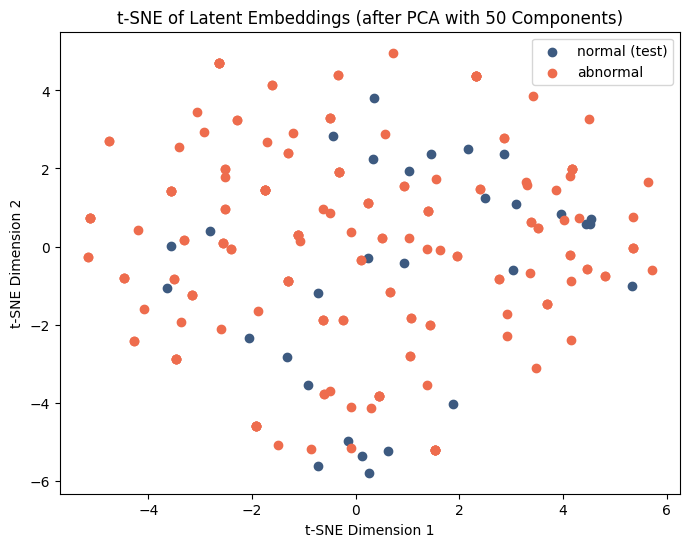

In [116]:

embeddings_list = list(evaluator.label_latent_dict.values())
embeddings = np.concatenate(embeddings_list, axis=0).squeeze()
categories = np.concatenate([[i]*len(emb) for i, emb in enumerate(embeddings_list)], axis=0).squeeze()
categories_list = list(evaluator.label_latent_dict.keys())

pca = PCA(n_components=50)
embeddings_50D = pca.fit_transform(embeddings)
print(embeddings_50D.shape)

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=100)
embeddings_2d = tsne.fit_transform(embeddings_50D)


print(embeddings_2d.shape, embeddings.shape, categories.shape)

plt.figure(figsize=(8, 6))
unique_categories = np.unique(categories)
# for i in range(len(unique_categories)):
#     category = unique_categories[i]
#     indices = np.where(categories == category)
    
#     print(np.where(categories == category))
#     # label = "normal" if categories_list[category] == "normal" else "anomaly"
#     plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=categories_list[category])
# indices = np.where(categories == categories_list.index("train"))
# plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label="normal (train)", c="#98c1d9")


normal_index = categories_list.index("normal")
indices = np.where(categories == normal_index)
plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label="normal (test)", c="#3d5a80")


# indices = np.where(~np.isin(categories, [normal_index, categories_list.index("train")]))
indices = np.where(~np.isin(categories, [normal_index]))
plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label="abnormal", c="#ee6c4d")





plt.title('t-SNE of Latent Embeddings (after PCA with 50 Components)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()


In [117]:
dl = train_data_module.train_dataloader()
for b in dl:
    print(b[0].shape)
    print(b[0].min(),b[0].max())
    break

torch.Size([1, 128, 128])
metatensor(-1.) metatensor(1.)


## Stats

In [118]:
# evaluator.normalize_scores()
evaluator.print_stats_table()

                    Statistics of Anomaly Scores per categroy                    
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Pathology           ┃ Minimum ┃ Maximum ┃ Median ┃ Mean ┃ Variance ┃ #Samples ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ absent_septum       │    0.32 │    0.32 │   0.32 │ 0.32 │     0.00 │        1 │
│ artefacts           │    0.13 │    0.58 │   0.32 │ 0.35 │     0.02 │       16 │
│ craniatomy          │    0.19 │    0.66 │   0.33 │ 0.38 │     0.02 │       15 │
│ dural               │    0.22 │    0.41 │   0.29 │ 0.32 │     0.00 │        7 │
│ ea_mass             │    0.19 │    0.40 │   0.29 │ 0.30 │     0.01 │        4 │
│ edema               │    0.14 │    0.45 │   0.24 │ 0.26 │     0.01 │       18 │
│ encephalomalacia    │    0.43 │    0.43 │   0.43 │ 0.43 │     0.00 │        1 │
│ enlarged_ventricles │    0.11 │    0.69 │   0.43 │ 0.44 │     0.03 │       19 │
│ intraventricular    │    0.46 │    0.46 │   0.46 │ 0.46 │     0.00 │        1 │
│ lesions             │    0.13 │    0.55 │   0.38 │ 0.37 │     0.01 │       22 │
│ mass                │    0.03 │    0.44 │   0.27 │ 0.27 │     0.01 │       22 │
│ posttreatment       │    0.02 │    0.66 │   0.29 │ 0.31 │     0.02 │       44 │
│ resection           │    0.22 │    0.66 │   0.43 │ 0.42 │     0.02 │       10 │
│ sinus               │    0.24 │    0.34 │   0.29 │ 0.29 │     0.00 │        2 │
│ wml                 │    0.26 │    0.44 │   0.43 │ 0.36 │     0.01 │        5 │
│ other               │    0.24 │    0.46 │   0.34 │ 0.36 │     0.01 │        5 │
│ normal              │    0.00 │    1.00 │   0.25 │ 0.29 │     0.05 │       30 │
└─────────────────────┴─────────┴─────────┴────────┴──────┴──────────┴──────────┘

In [119]:
# train_evaluator.print_stats_table()

## Histograms

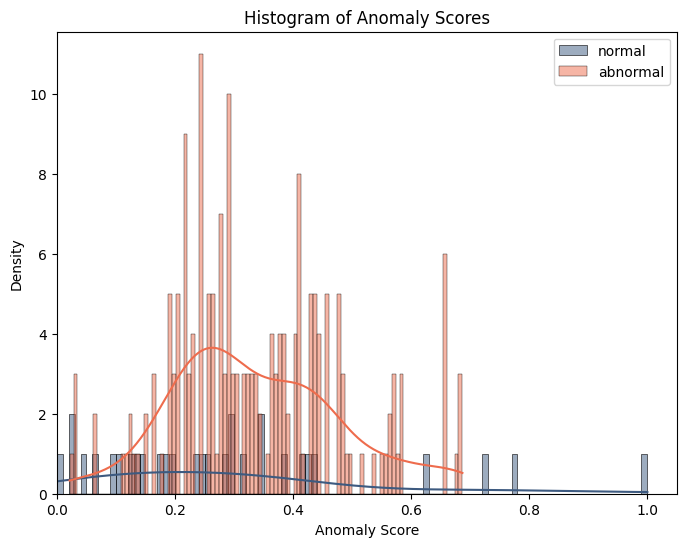

In [120]:
evaluator.histplot()

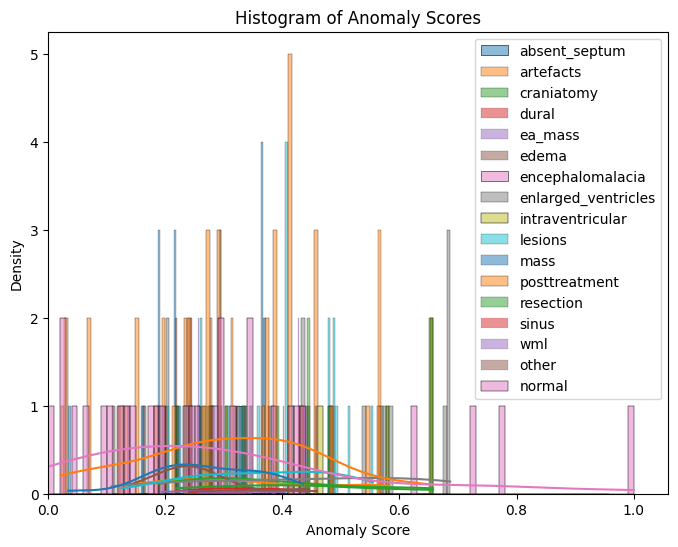

In [121]:
evaluator.histplot(eval_type=EvalType.ALL)

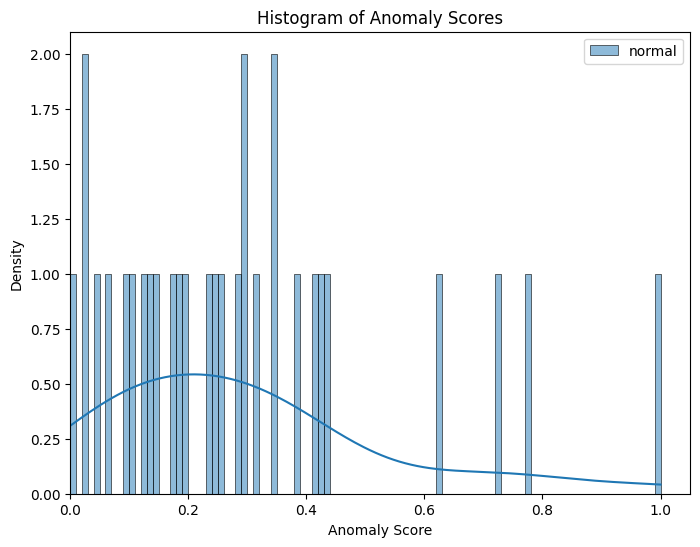

In [122]:
evaluator.histplot(EvalType.NORMAL)

tra

In [123]:
# train_evaluator.histplot(EvalType.TRAIN)

# Metrics

## Find optimal threshold

In [124]:
# optimal_threshold = evaluator.find_optimal_threshold_f1()
# print(optimal_threshold)
# if optimal_threshold == 0:
#     optimal_threshold = 0.03
optimal_threshold = 0.1

## General classification report

In [125]:
evaluator.classification_report(threshold=optimal_threshold)

              precision    recall  f1-score   support

           0       0.50      0.20      0.29        30
           1       0.89      0.97      0.93       192

    accuracy                           0.86       222
   macro avg       0.69      0.58      0.61       222
weighted avg       0.83      0.86      0.84       222



## Confusion matrix

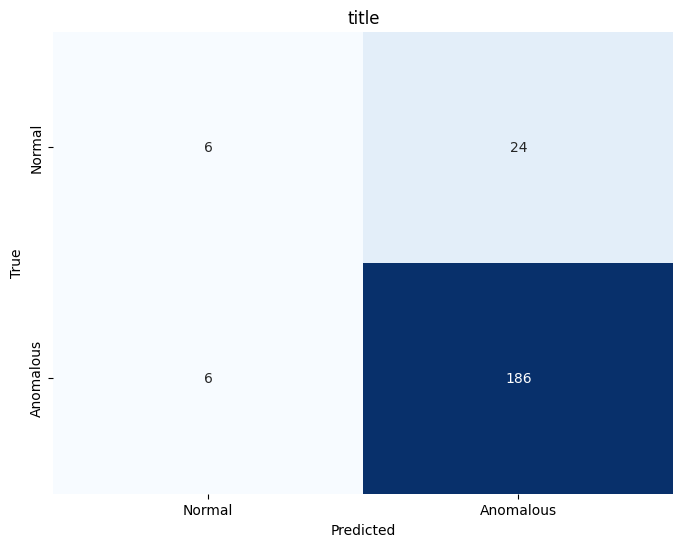

In [126]:
evaluator.plot_confusion_matrix(threshold=optimal_threshold)

## AUROC

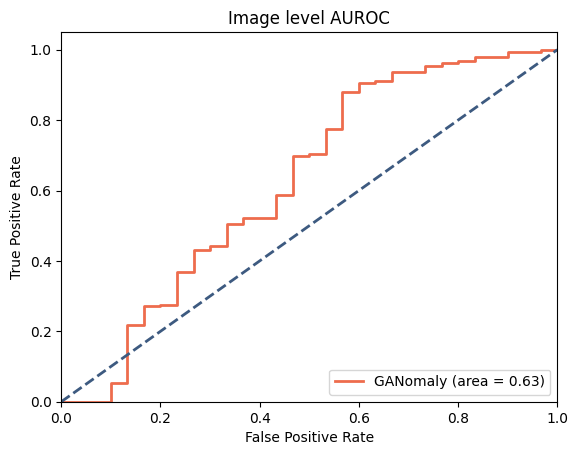

In [127]:
# evaluator.roc_auc_score()
evaluator.plot_auroc(save_fig=True)


## PRC AUC

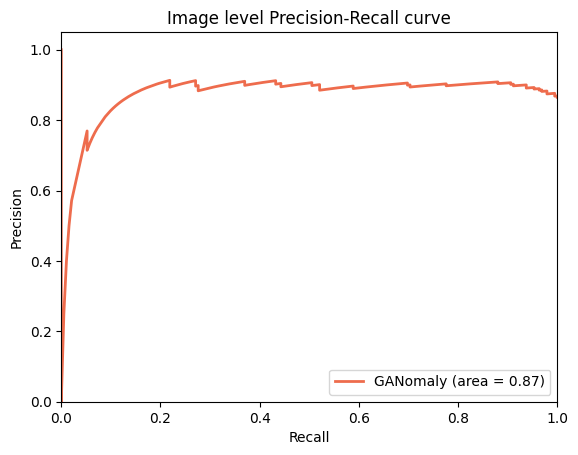

In [128]:
# evaluator.prc_auc_score()
evaluator.plot_auprc(save_fig=True)

# Reconstructions

## Test set - Normal data

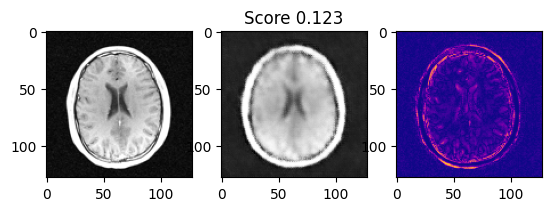

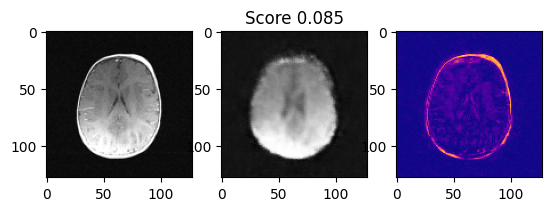

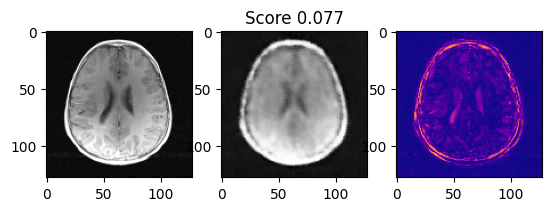

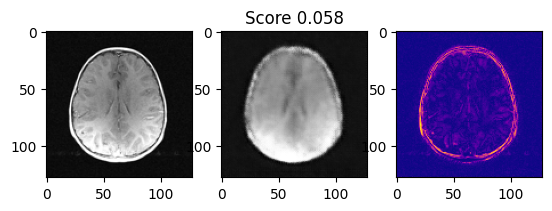

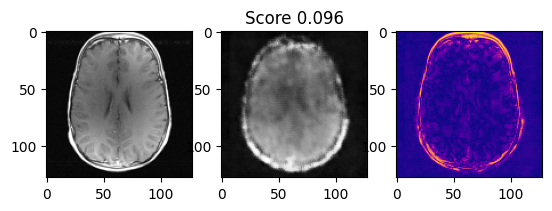

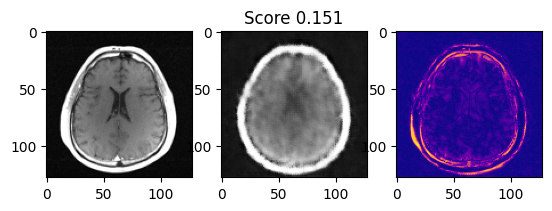

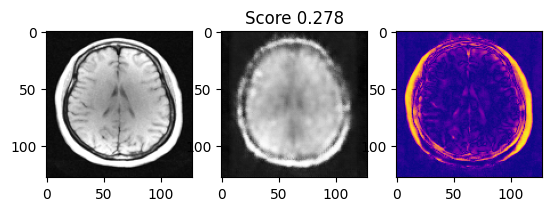

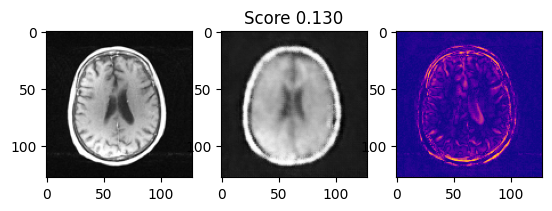

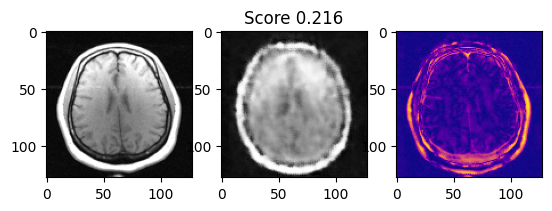

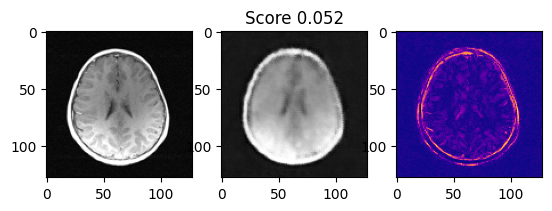

In [129]:
evaluator.plot_in_rec(label="normal", n=10)

## Recon for normal train data

In [130]:
# input_reconstructions_tuples = train_evaluator.label_in_rec_dict["train"]
# N = 8
# fig, ax = plt.subplots(N, 3, figsize=(3,N))
# for i in range(N):
#     input_img, reconstruction_img = input_reconstructions_tuples[i]
#     ax[i][0].imshow(input_img.transpose(1, 2, 0), cmap="gray")
#     # ax[i][0].set_title("Input")
#     ax[i][1].imshow(reconstruction_img.transpose(1, 2, 0), cmap="gray")
#     # ax[i][1].set_title("Reconstruction")
#     diff = input_img - reconstruction_img
#     ax[i][2].imshow(diff.transpose(1, 2, 0), cmap="viridis_r")
#     # ax[i][2].set_title("Difference")
# for ax in ax.flatten():
#     ax.set_xticks([])
#     ax.set_yticks([])
# plt.tight_layout()
# plt.show()

In [131]:
# train_evaluator.plot_in_rec(label="train", n=32)


## Recon for abnormal

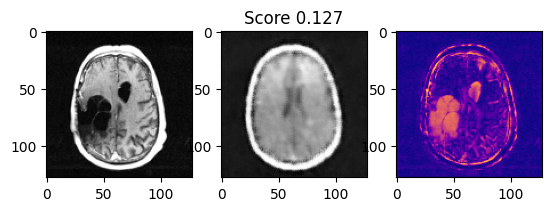

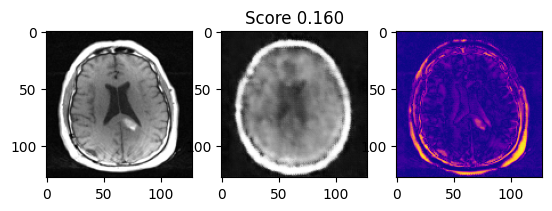

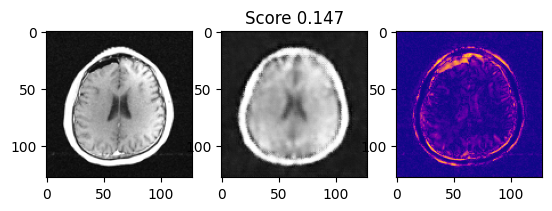

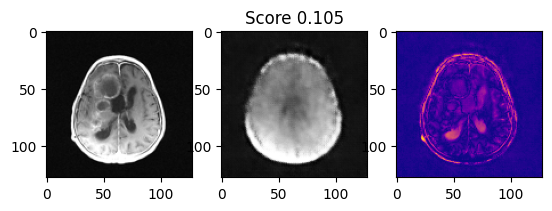

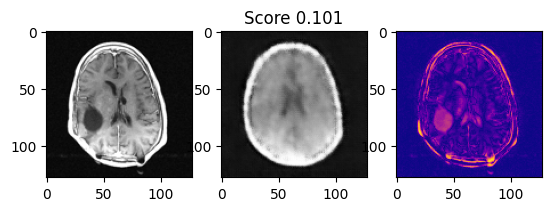

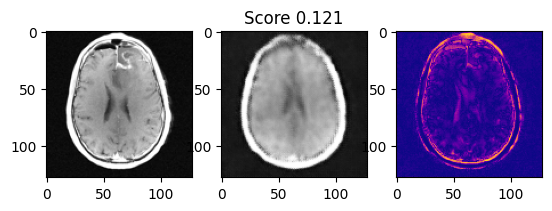

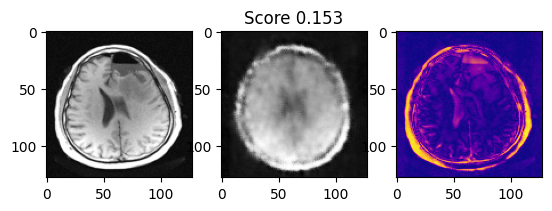

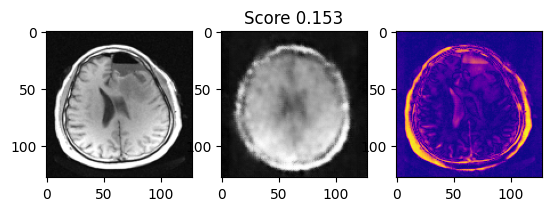

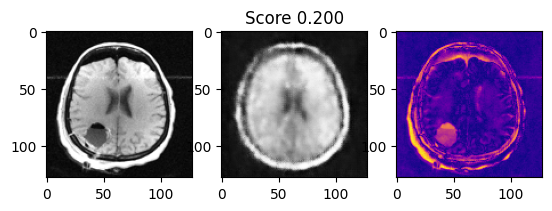

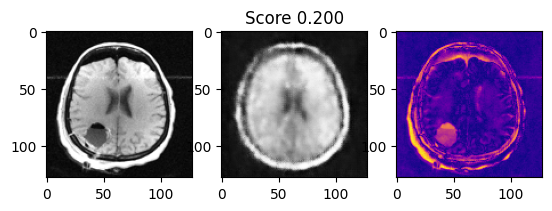

In [132]:
evaluator.plot_in_rec(label="resection", n=10)

In [133]:
# fig_example.savefig(f"example_{config['num_epochs']}.png")